In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append('..')

import modules.stats as st
import modules.plotting as pl
import modules.pandas_funcs as pf

In [2]:
results_dir = os.path.join('..', 'data', 'results')
match_dir = os.path.join('..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Add file names to individual DataFrames
df_k['File'] = df_match.Kinect
df_z['File'] = df_match.Zeno

# Merge extra series into Kinect DataFrame
df_k = pd.merge(df_k, df_k_raw.head_distance.to_frame(), left_on='File', right_index=True)

## Visual Results

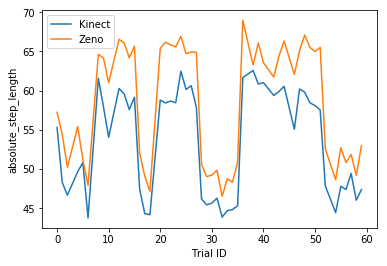

In [3]:
%matplotlib inline

metric = 'absolute_step_length'

plt.plot(df_k[metric])
plt.plot(df_z[metric])

plt.xlabel('Trial ID')
plt.ylabel(metric)

plt.legend(['Kinect', 'Zeno'])
plt.show()

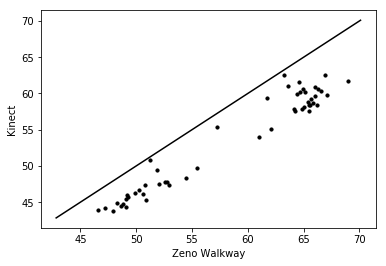

In [4]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
metric = 'absolute_step_length'
    
pl.compare_measurements(df_z[metric], df_k[metric], c='k', s=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

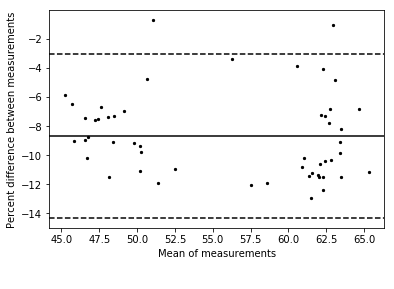

In [5]:
metric = 'absolute_step_length'

# Bland-Altman object
bland_obj = st.BlandAltman(df_k[metric], df_z[metric], percent=True)

pl.plot_bland_altman(bland_obj.means, bland_obj.differences, bland_obj.bias, 
                     bland_obj.limits_of_agreement, percent=True)

## Quantitative Results

In [6]:
funcs = {'Pearson': lambda a, b: pearsonr(a, b)[0],
        'Spearman': lambda a, b: spearmanr(a, b)[0],
        'Abs rel error': lambda a, b: st.relative_error(a, b, absolute=True).mean(),
        'Bias': lambda a, b: st.BlandAltman(a, b).bias, 
        'Range': lambda a, b: st.BlandAltman(a, b).range}
 
    
d = {name: pf.apply_to_columns(df_k, df_z, func) for name, func in funcs.items()}

df_results = pd.DataFrame(d).T
df_results

,absolute_step_length,step_length,stride_length,stride_time,stride_velocity,stride_width
Pearson,0.973093,0.942524,0.878518,0.926200,0.961662,0.801217
Spearman,0.882030,0.834970,0.809613,0.693634,0.832665,0.784086
Abs rel error,0.082752,0.113937,0.150830,0.594151,0.085160,2.195679
Bias,-0.086716,-0.122292,-0.168770,-0.847419,0.062615,0.961414
Range,0.112487,0.222220,0.503524,0.310352,0.284897,8.543376
